This portion of the analysis will focus on private planes. We define a private plane as one which carries less than 20 passengers total. Private planes generally have either 1 or 2 engines. Our goal will be to determine the safest make and model of private planes, as well as whether it is safer to have 1 or 2 engines.

We begin by importing and filtering the data. We filtered it to look only at US flights which occurred after the creation of the TSA on November 19, 2001. We also removed several columns which were not necessary to our analysis.

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df=pd.read_csv('../data/Aviation_Data.csv', encoding="latin-1", low_memory=False)#, parse_dates=['Event.Date'])

In [22]:
df.head()

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,Purpose.of.flight,Air.carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date
0,20001218X45444,Accident,SEA87LA080,1948-10-24,"MOOSE CREEK, ID",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,UNK,Cruise,Probable Cause,NaN
1,20001218X45447,Accident,LAX94LA336,1962-07-19,"BRIDGEPORT, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,4.0,0.0,0.0,0.0,UNK,Unknown,Probable Cause,19-09-1996
2,20061025X01555,Accident,NYC07LA005,1974-08-30,"Saltville, VA",United States,36.922223,-81.878056,NaN,NaN,...,Personal,NaN,3.0,NaN,NaN,NaN,IMC,Cruise,Probable Cause,26-02-2007
3,20001218X45448,Accident,LAX96LA321,1977-06-19,"EUREKA, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,IMC,Cruise,Probable Cause,12-09-2000
4,20041105X01764,Accident,CHI79FA064,1979-08-02,"Canton, OH",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,1.0,2.0,NaN,0.0,VMC,Approach,Probable Cause,16-04-1980


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90348 entries, 0 to 90347
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event.Id                88889 non-null  object 
 1   Investigation.Type      90348 non-null  object 
 2   Accident.Number         88889 non-null  object 
 3   Event.Date              88889 non-null  object 
 4   Location                88837 non-null  object 
 5   Country                 88663 non-null  object 
 6   Latitude                34382 non-null  object 
 7   Longitude               34373 non-null  object 
 8   Airport.Code            50249 non-null  object 
 9   Airport.Name            52790 non-null  object 
 10  Injury.Severity         87889 non-null  object 
 11  Aircraft.damage         85695 non-null  object 
 12  Aircraft.Category       32287 non-null  object 
 13  Registration.Number     87572 non-null  object 
 14  Make                    88826 non-null

In [24]:
df = df.rename(columns={c: c.title().replace('.', '_') for c in df.columns})
usa=df.loc[(df['Country']=='United States') & (df['Event_Date']>='2001-11-19')]

Next, we will clean up some of the columns which have missing values. We will begin with the columns containing data on injuries and fatalities. From examining the "Injury Severity" column we can see that all the missing values in the "Total_Fatal_Injuries" column correspond to a value of "Non-Fatal" in "Injury_Severity". Therefore we will see these missing values equal to zero in the "Total_Fatal_Injuries" column.

In [25]:
usa.loc[usa['Total_Fatal_Injuries'].isna(), 'Total_Fatal_Injuries']=0

c:\Users\jimmy\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


The "Total.Uninjured" column contains missing values. This column will be important, as we need to know the number of passengers to distinguish private from commercial flights. For this column we will impute the median value, which is 1, into the null values.

There are two other columns containing data on serious and minor injuries. Many of these contain missing values too. Our approach to this will be to look at the ratio of minor/serious injuries in the dataset to the total number of uninjured patients in the dataset. We will use this ratio to impute missing values.

In [26]:
minor_injuries=usa.loc[(usa['Total_Uninjured'].notna()) & (usa['Total_Minor_Injuries'].notna())]
minor_injuries_ratio=minor_injuries['Total_Minor_Injuries'].sum()/minor_injuries['Total_Uninjured'].sum()

serious_injuries=usa.loc[(usa['Total_Uninjured'].notna()) & (usa['Total_Serious_Injuries'].notna())]
serious_injuries_ratio=serious_injuries['Total_Serious_Injuries'].sum()/serious_injuries['Total_Uninjured'].sum()

usa.loc[usa['Total_Uninjured'].isna(), 'Total_Uninjured']=usa['Total_Uninjured'].median()
usa.loc[usa['Total_Minor_Injuries'].isna(), 'Total_Minor_Injuries']=round(minor_injuries_ratio*usa['Total_Uninjured'], 0)
usa.loc[usa['Total_Serious_Injuries'].isna(), 'Total_Serious_Injuries']=round(serious_injuries_ratio*usa['Total_Uninjured'], 0)


c:\Users\jimmy\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


Now that we have filled in the missing values for the injuries and fatalities columns, we can add up the values of all these columns to get the number of passengers. Doing so will allow us to distinguish private planes vs commercial ones.

In [27]:
usa['Passengers']=usa['Total_Uninjured']+usa['Total_Minor_Injuries']+usa['Total_Serious_Injuries']+usa['Total_Fatal_Injuries']

<ipython-input-27-fad06e55e0b5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usa['Passengers']=usa['Total_Uninjured']+usa['Total_Minor_Injuries']+usa['Total_Serious_Injuries']+usa['Total_Fatal_Injuries']


In [28]:
private_planes=usa.loc[usa['Passengers']<20]

In [29]:
private_planes

,Event_Id,Investigation_Type,Accident_Number,Event_Date,Location,Country,Latitude,Longitude,Airport_Code,Airport_Name,...,Air_Carrier,Total_Fatal_Injuries,Total_Serious_Injuries,Total_Minor_Injuries,Total_Uninjured,Weather_Condition,Broad_Phase_Of_Flight,Report_Status,Publication_Date,Passengers
51801,20011128X02307,Accident,FTW02FA037,2001-11-19,"PATTERSON, LA",United States,29.713333,-91.331945,PTN,Harry P. Williams Memorial,...,NaN,1.0,0.0,0.0,1.0,VMC,Takeoff,Probable Cause,30-05-2003,2.0
51802,20011129X02313,Accident,MIA02LA035,2001-11-20,"FAIRHOPE, AL",United States,30.461667,-87.9,AL78,Klumpp Field,...,NaN,0.0,0.0,0.0,2.0,IMC,Landing,Probable Cause,20-02-2002,2.0
51803,20011130X02325,Accident,MIA02LA028,2001-11-20,"STUART, FL",United States,27.083056,-80.341111,NaN,NaN,...,NaN,0.0,0.0,1.0,1.0,VMC,Approach,Probable Cause,28-05-2002,2.0
51804,20011203X02331,Accident,MIA02LA025,2001-11-20,"EVANS, GA",United States,33.371945,-82,NaN,NaN,...,NaN,0.0,1.0,0.0,1.0,VMC,Cruise,Probable Cause,01-04-2003,2.0
51805,20011127X02302,Accident,MIA02LA024,2001-11-20,"CRYSTAL RIVER, FL",United States,NaN,NaN,CGC,Crystal River Airport,...,NaN,0.0,0.0,0.0,1.0,VMC,Taxi,Probable Cause,05-02-2002,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90343,20221227106491,Accident,ERA23LA093,2022-12-26,"Annapolis, MD",United States,NaN,NaN,NaN,NaN,...,NaN,0.0,1.0,0.0,0.0,NaN,NaN,NaN,29-12-2022,1.0
90344,20221227106494,Accident,ERA23LA095,2022-12-26,"Hampton, NH",United States,NaN,NaN,NaN,NaN,...,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0
90345,20221227106497,Accident,WPR23LA075,2022-12-26,"Payson, AZ",United States,341525N,1112021W,PAN,PAYSON,...,NaN,0.0,0.0,0.0,1.0,VMC,NaN,NaN,27-12-2022,1.0
90346,20221227106498,Accident,WPR23LA076,2022-12-26,"Morgan, UT",United States,NaN,NaN,NaN,NaN,...,MC CESSNA 210N LLC,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0


We now have a subset of the data that focuses on planes estimated to be carrying less than 20 passengers. We will examine the distributions of make and model to determine what recommendations should be made. First, we will clean up these columns by removing rows with null values (there are very few).

In [30]:
private_planes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31215 entries, 51801 to 90347
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event_Id                31215 non-null  object 
 1   Investigation_Type      31215 non-null  object 
 2   Accident_Number         31215 non-null  object 
 3   Event_Date              31215 non-null  object 
 4   Location                31208 non-null  object 
 5   Country                 31215 non-null  object 
 6   Latitude                30623 non-null  object 
 7   Longitude               30613 non-null  object 
 8   Airport_Code            21205 non-null  object 
 9   Airport_Name            21392 non-null  object 
 10  Injury_Severity         31107 non-null  object 
 11  Aircraft_Damage         30726 non-null  object 
 12  Aircraft_Category       23873 non-null  object 
 13  Registration_Number     31192 non-null  object 
 14  Make                    31203 non-

In [31]:
private_planes=private_planes.dropna(subset=['Make', 'Model'])

We will also clean up some duplicate names in the 'Make' column. 

In [32]:
private_planes['Make']=private_planes['Make'].str.title()

<ipython-input-32-ee8d3351dcfd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  private_planes['Make']=private_planes['Make'].str.title()


Next we will create visualizations to see which makes and models are most commonly involved in crashes, as well as which ones have the highest number of fatalities. We will examine the 20 most common of each.

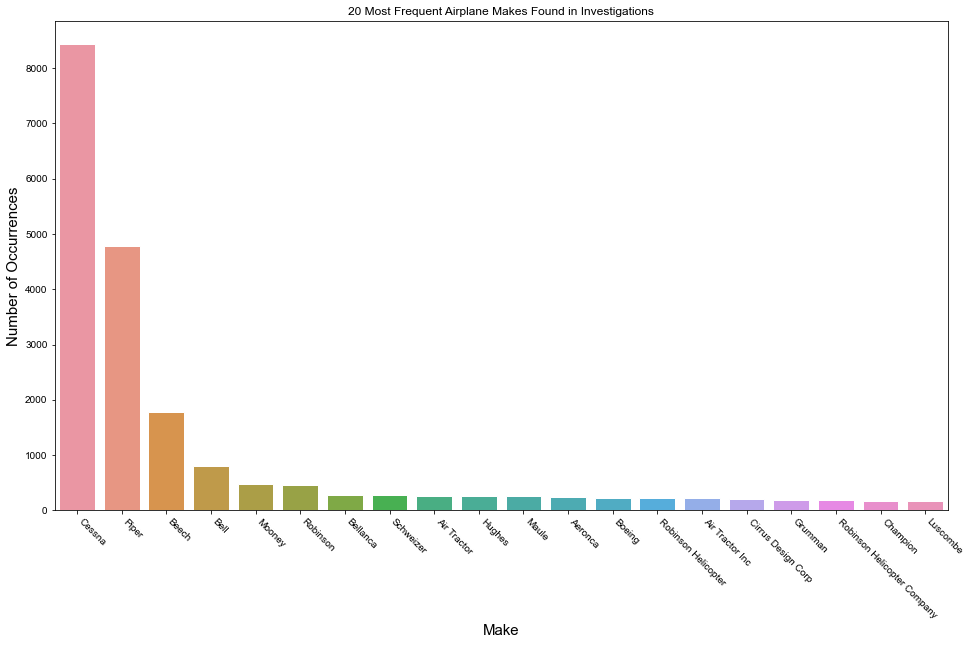

In [33]:
fig, ax=plt.subplots(figsize=(16,9))
sns.set_style('darkgrid')
makes=sns.barplot(data=private_planes, x=private_planes['Make'].value_counts().index[:20], y=private_planes['Make'].value_counts().values[:20])
makes.set_title('20 Most Frequent Airplane Makes Found in Investigations')
makes.set_xlabel('Make', fontsize=15)
makes.set_ylabel('Number of Occurrences', fontsize=15)
makes.set_xticklabels(private_planes['Make'].value_counts().index[:20], rotation=-45, ha='left');

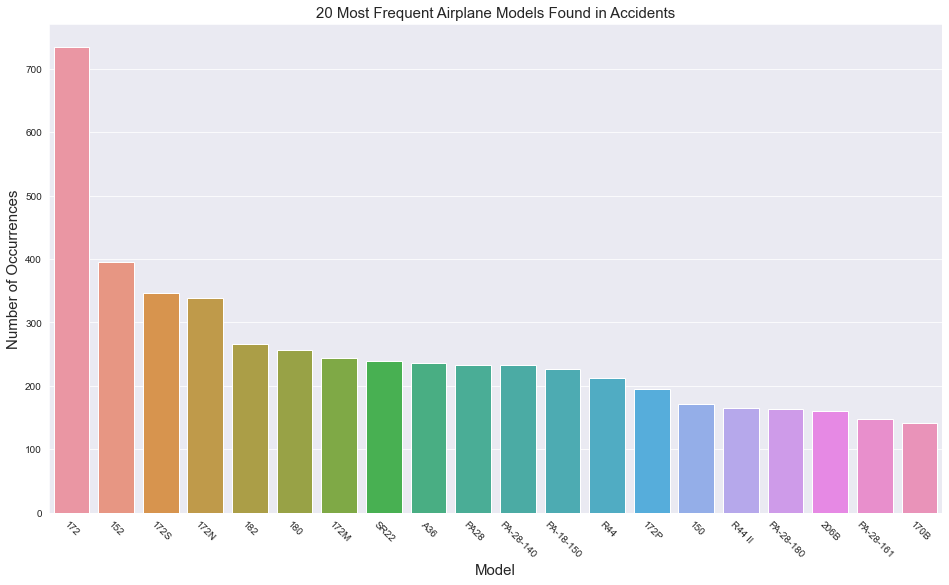

In [34]:
fig, ax=plt.subplots(figsize=(16,9))
sns.set_style('darkgrid')
makes=sns.barplot(data=private_planes, x=private_planes['Model'].value_counts().index[:20], y=private_planes['Model'].value_counts().values[:20])
makes.set_title('20 Most Frequent Airplane Models Found in Accidents', fontsize=15)
makes.set_xlabel('Model', fontsize=15)
makes.set_ylabel('Number of Occurrences', fontsize=15)
makes.set_xticklabels(private_planes['Model'].value_counts().index[:20], rotation=-45, ha='center');

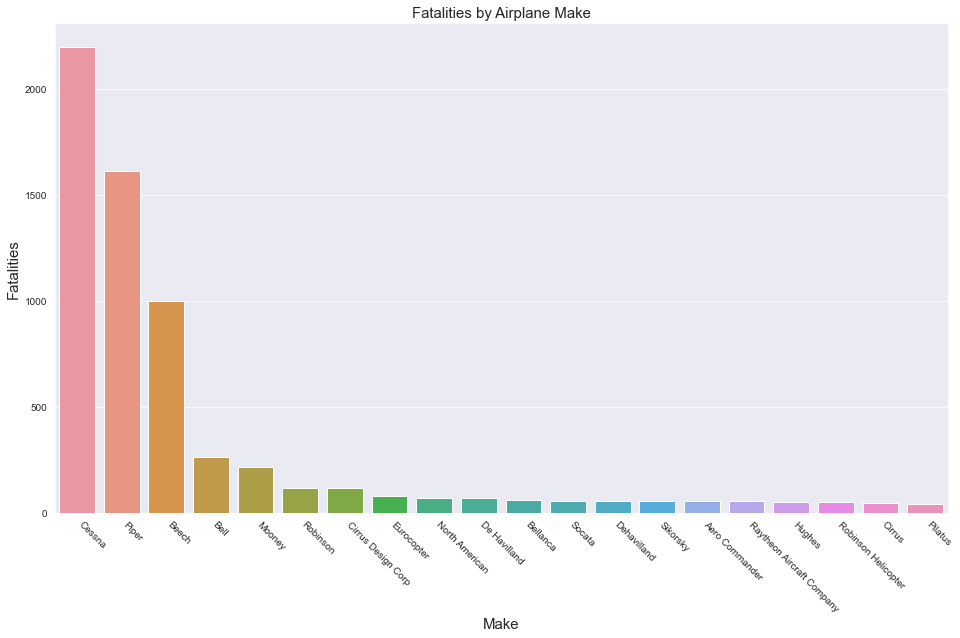

In [35]:
fatalities=private_planes.groupby('Make')['Total_Fatal_Injuries'].sum().sort_values(ascending=False)

fig, ax=plt.subplots(figsize=(16,9))
sns.set_style('darkgrid')
f=sns.barplot(data=private_planes, x=fatalities.index[:20], y=fatalities.values[:20])
f.set_title('Fatalities by Airplane Make', fontsize=15)
f.set_xlabel('Make', fontsize=15)
f.set_ylabel('Fatalities', fontsize=15)
f.set_xticklabels(fatalities.index[:20], rotation=-45, ha='left');

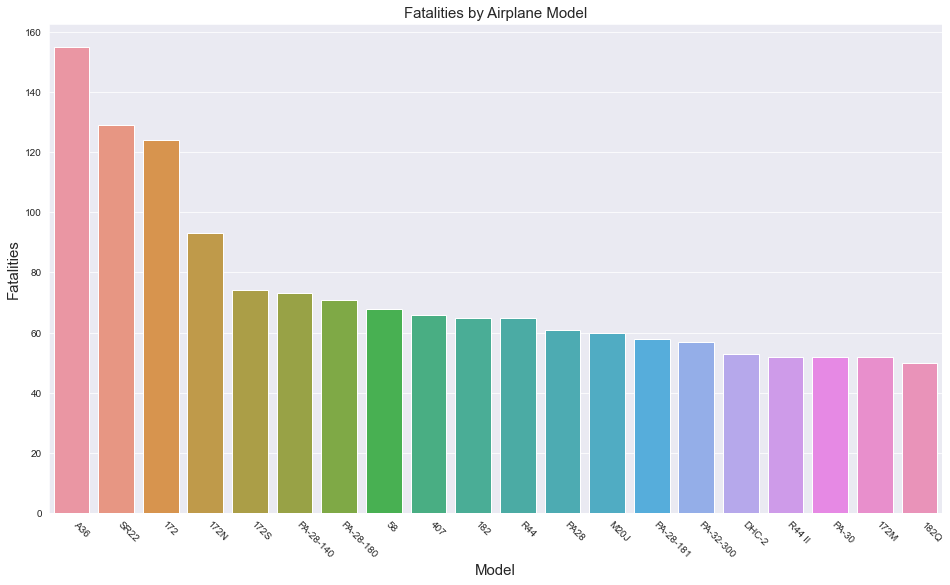

In [36]:
fatalities=private_planes.groupby('Model')['Total_Fatal_Injuries'].sum().sort_values(ascending=False)

fig, ax=plt.subplots(figsize=(16,9))
sns.set_style('darkgrid')
f=sns.barplot(data=private_planes, x=fatalities.index[:20], y=fatalities.values[:20])
f.set_title('Fatalities by Airplane Model', fontsize=15)
f.set_xlabel('Model', fontsize=15)
f.set_ylabel('Fatalities', fontsize=15)
f.set_xticklabels(fatalities.index[:20], rotation=-45, ha='left');

We can see that although Cessna has nearly twice as many investigations as Piper, the difference in fatalities is less stark. As for models, the 172 was the most common model investigated but accounted for only the 3rd most deaths. The A36 model accounted for the most fatalities, despite being only the 9th most common model involved in investigations.

Ultimately a plane cannot be several types of makes and models -it can only be one. Therefore the next step in our analysis will be to combine make and model into one column, and use this column to make our final recommendations. Specifically, we will look to see which models have the highest percentage of deaths and injuries out of their total passengers, and which have the lowest.

In [37]:
private_planes['Plane']=private_planes['Make'].str[0:] + ' ' + private_planes['Model'].str[0:]

<ipython-input-37-db04ccf58c64>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  private_planes['Plane']=private_planes['Make'].str[0:] + ' ' + private_planes['Model'].str[0:]


In [38]:
private_planes['Fatality_Rate']=private_planes['Total_Fatal_Injuries']/private_planes['Passengers']

<ipython-input-38-a49ae135960c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  private_planes['Fatality_Rate']=private_planes['Total_Fatal_Injuries']/private_planes['Passengers']


In [39]:
death_rates=private_planes.groupby('Plane')['Total_Fatal_Injuries'].sum()/private_planes.groupby('Plane')['Passengers'].sum()
deadly_planes=private_planes.groupby('Plane')['Total_Fatal_Injuries'].sum().sort_values(ascending=False)
top_20=death_rates.loc[death_rates.index.isin(deadly_planes[:20].index)]
top_20=top_20.sort_values(ascending=False)

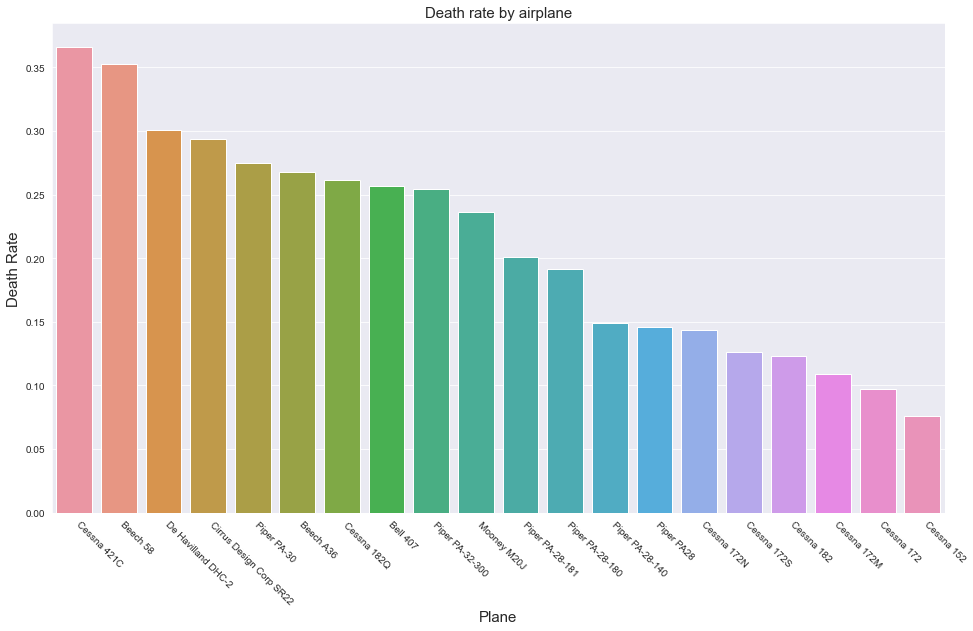

In [40]:
fig, ax=plt.subplots(figsize=(16,9))
sns.set_style('darkgrid')
f=sns.barplot(data=private_planes, x=top_20.index, y=top_20.values)
f.set_title('Death rate by airplane', fontsize=15)
f.set_xlabel('Plane', fontsize=15)
f.set_ylabel('Death Rate', fontsize=15)
f.set_xticklabels(top_20.index, rotation=-45, ha='left');

We can see from this visualization some of the planes with the highest death rates. Since our goal is to find planes that are safer, we will need to conduct further analysis. We will look at all planes which flew more than 100 passengers total (to ensure we have a significant sample size). This comes out to 91 total make/models. From these 91 we will select those which tend to be the safest.

In [95]:
most_common_private_planes=private_planes.groupby('Plane')['Passengers'].sum().sort_values(ascending=False)[private_planes.groupby('Plane')['Passengers'].sum().sort_values(ascending=False).values>100]
top_private_planes=private_planes.loc[private_planes['Plane'].isin(most_common_private_planes.index)]
top_91_death_rates=top_private_planes.groupby('Plane')['Fatality_Rate'].mean().sort_values(ascending=False)

We will now show a bar graph with the fatality rates for each of these:

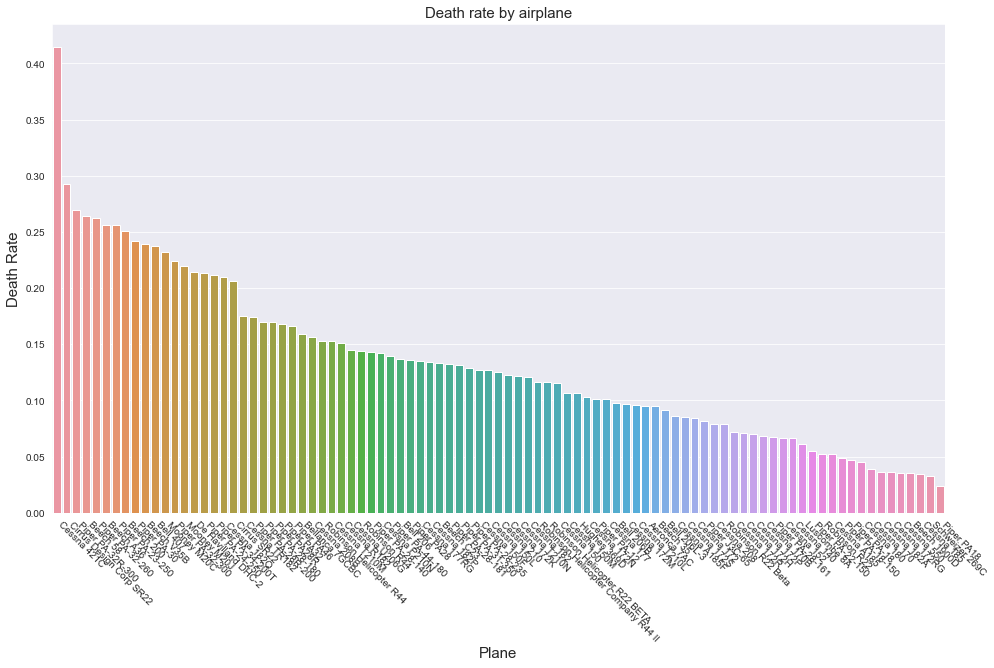

In [94]:
fig, ax=plt.subplots(figsize=(16,9))
sns.set_style('darkgrid')
f=sns.barplot(data=top_private_planes, x=top_91_death_rates.index, y=top_91_death_rates.values)
f.set_title('Death rate by airplane', fontsize=15)
f.set_xlabel('Plane', fontsize=15)
f.set_ylabel('Death Rate', fontsize=15)
f.set_xticklabels(top_91_death_rates.index, rotation=-45, ha='left');

That's a lot of bars...let's look at the 20 with the lowest death rates:

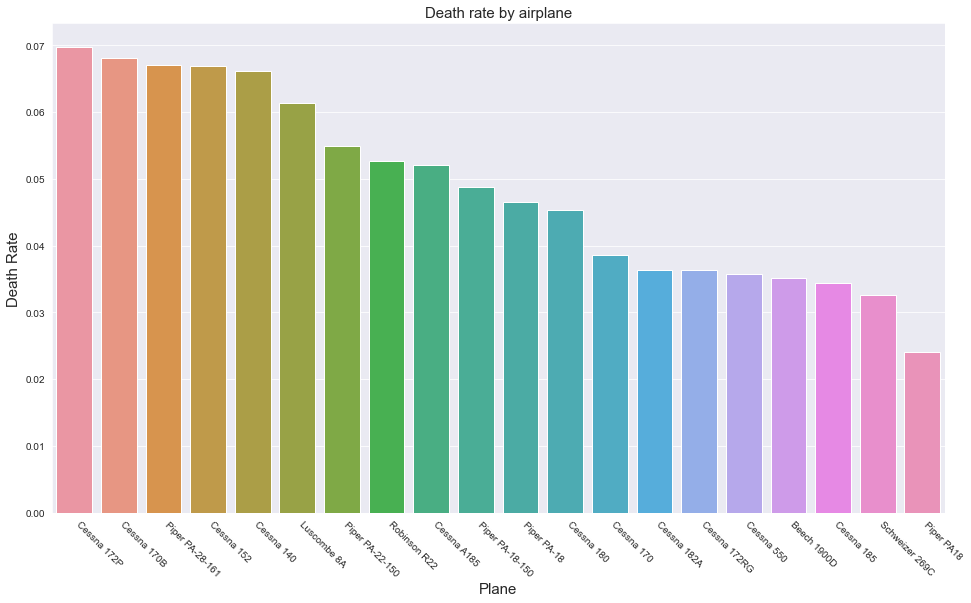

In [96]:
fig, ax=plt.subplots(figsize=(16,9))
sns.set_style('darkgrid')
f=sns.barplot(data=top_private_planes, x=top_91_death_rates.index[-20:], y=top_91_death_rates.values[-20:])
f.set_title('Death rate by airplane', fontsize=15)
f.set_xlabel('Plane', fontsize=15)
f.set_ylabel('Death Rate', fontsize=15)
f.set_xticklabels(top_91_death_rates.index[-20:], rotation=-45, ha='left');

We now have 20 planes which are commonly flown and had low death rates. We will use a similar method to find 20 planes with low injury rates: